# Bayesian Regression

In [1]:
import emcee
print(emcee.__version__)

3.1.2


Import Libraries:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp

Read the archive sn-data.csv:

In [3]:
SNCP = pd.read_csv("sn-data.csv")

Separate the values of redshift, distance modulus and its error in different variables:

In [4]:
z = SNCP['redshift'].values
u = SNCP['dist_mod'].values
u_err = SNCP['err_dist_mod'].values

Plot of the data points and its error (bars):

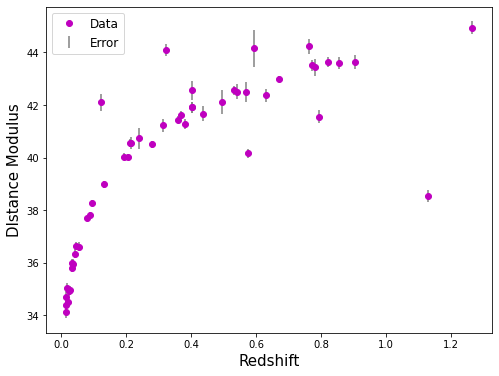

In [5]:
plt.figure(figsize=(8,6))

plt.plot(z,u,'mo', label = 'Data')
plt.errorbar(z, u, yerr = u_err, fmt='None',ecolor='gray', label = 'Error')

plt.xlabel('Redshift',size=15)
plt.ylabel('DIstance Modulus', size=15)
plt.legend(prop={'size':12})
plt.show('off')

Definiition of the model, the prior, the likelihood and the posterior:

In [6]:
from scipy import integrate

# Definition of the function of the integral 
def model(H0,Om,OA,x):
    y = lambda x: (Om*((1+x)**3)+OA)**(-1/2)
    return -5*np.log((1+x)*(3*(10**8)/H0)*sp.integrate.quad(y,0,x)[0])

# The parameters of the model are:

# H0 which is the Hubble Constant (much different values for this constant have been estimated but all of the are on the range of 50 to 100 approximately)
# Om which is the Matter density (so as it is normalized, it can only take values between 0 and 1)
# OA which is the Cosmological Constant (the range from 0.5 to 0.9 is choosen as its value is approximately 0.73)
# Pb is the binomial probability of the bad points (as it is a probability it can only take values from 0 to 1)
# Yb which is the mean of the gaussian from where the outliers are drawn (we have choosen the range from 0 to 100)
# Vb which is the variance of the gaussian from where the outliers are drawn (in this case we have taken the logVb for practical reasons and the range choosen is from -5 to 10)

# Definition of the prior which is flat, so we set a range of values for each parameter, and as we are using the logVb, the parameter Vb, as it is a variance, should not be negative 
def ln_prior(theta):
    H0, Om, OA, Pb, Yb, logVb = theta 
    if 50 < H0 < 100 and 0 < Om < 1 and 0.5 < OA < 0.9 and 0 < Pb < 1 and 0 < Yb < 100 and -5 < logVb < 10:
        return 0
    return -np.inf

# Definition of the likelihood 
def ln_likelihood(theta, z, u, uerr):
    H0, Om, OA, Pb, Yb, logVb = theta 
    Vb = 10**logVb
    # Model Fitting to the z data 
    lista=[]
    for i in range(len(z)): 
        lista.append(model(H0,Om,OA,z[i]))
    p_fg = (1-Pb) / np.sqrt(2 * np.pi * uerr**2) * np.exp(-(u-lista)**2/(2 * uerr**2))
    p_bg = Pb / np.sqrt(2 * np.pi * (Vb + uerr**2)) * np.exp(-(u - Yb)**2/(2 * (Vb + uerr**2)))
    output = np.sum(np.log(p_fg + p_bg))
    return output

# Definition of the posterior 
def ln_posterior(theta, z, u, uerr):
    ln_p = ln_prior(theta)
    if not np.isfinite(ln_p):
        return -np.inf
    return ln_p + ln_likelihood(theta, z, u, uerr)

Initial values and positions of the walkers:

In [7]:
# Using a seed to fix the random values for the initial position of the walkers
np.random.seed(6346)

# Initial values of all the model parameters
theta_0 = np.array([71, 0.27, 0.73, 0.4, 40., 1.]) 

# Number of dimensions and walkers
ndim, nwalkers = 6, 32

# Initial Position
pos_0 = [theta_0 + 0.1*np.random.randn(ndim) for i in range(nwalkers)]

# Defining the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_posterior, 
                                args=(z, u, u_err), threads=8)

Running the sampler:

In [8]:
%timeit -n1 -r1 sampler.run_mcmc(pos_0, 1000);

25 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Corner Plot:

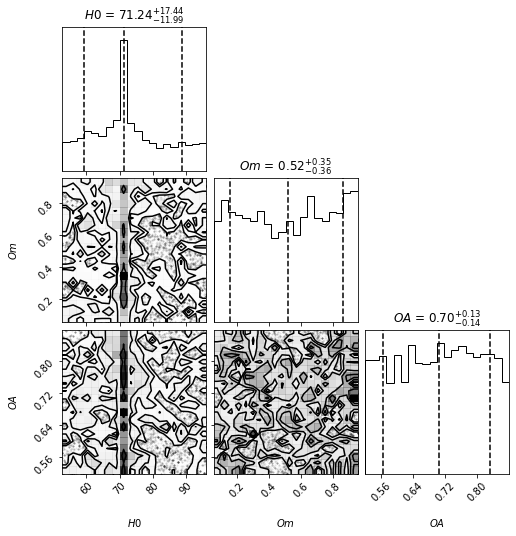

In [9]:
import corner

fig = corner.corner(sampler.flatchain[:,[0, 1, 2]], 
                    labels=["$H0$", "$Om$", "$OA$"], 
                    range=(0.9, 0.9, 0.9),
                    quantiles=[0.16, 0.5, 0.84],
                    show_titles=True, title_kwargs={"fontsize": 12})

From the corner plot, we can se the joint probability distribution of the three free parameters of the model: H0, Om and OA. 

The most probable value of the three parameters obtained are:
H0 = 71.24 (-11.99,+17.44)
Om = 0.52 (-0.36,+0.35)
OA = 0.70 (-0.14,+0.13)

From that, we can see that the estimation is very precise beacuse the values are closed to the theoretical ones, which are:
H0 = 71 
Om = 0.27 
OA = 0.73